In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join as pjoin
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from scipy.stats import linregress
from sklearn.model_selection import KFold

import matplotlib
font = {"size": 20}
matplotlib.rc("font", **font)
matplotlib.rcParams["text.usetex"] = True

import sys

sys.path.append("../../models")
from linear_cr_new import LinearContrastiveRegression
from pcpca import PCPCA


In [2]:
data_dir = "./data/"
X = np.load(pjoin(data_dir, "foreground.npy"))
Y = np.load(pjoin(data_dir, "background.npy"))
R = np.load(pjoin(data_dir, "foreground_labels.npy")).reshape(-1, 1)

# Should have same number of features
assert X.shape[0] == Y.shape[0]

X_mean, Y_mean, R_mean = np.mean(X, axis=0), np.mean(Y, axis=0), np.mean(R, axis=0)
X = (X - X_mean) / np.std(X, axis=0)
Y = (Y - Y_mean) / np.std(Y, axis=0)
R = (R - R_mean) / np.std(R, axis=0)

n, p = X.shape
m, _ = Y.shape
d = 2

In [11]:
# Now do this prediction experiment on held-out data
n_splits = 3
r2_scores_contrastivereg = []
r2_scores_pcpca = []
r2_scores_linreg = []

kf = KFold(n_splits=n_splits, shuffle=True)
for train_index, test_index in kf.split(X):
    
    # Train/test split
    X_train, Y_train, R_train = X[train_index], Y[train_index], R[train_index]
    X_test, Y_test, R_test = X[test_index], Y[test_index], R[test_index]
    
    # Fit model on training data
    model = LinearContrastiveRegression()
    model.fit(X_train, Y_train, R_train, d, print_every=100)
    
    # Make predictions
    preds_contrastivereg = model.predict(X_test)
    
    # Compute R^2
    _, _, r2_contrastivereg, _, _ = linregress(R_test.squeeze(), preds_contrastivereg)
    r2_scores_contrastivereg.append(r2_contrastivereg)
    
    # PCPCA
    linreg = LinearRegression()
    pcpca = PCPCA(gamma=0.9, n_components=d)
    pcpca.fit(np.transpose(X), np.transpose(Y))
    X_reduced, _ = pcpca.fit_transform(np.transpose(X), np.transpose(Y))
    X_reduced = np.transpose(X_reduced)
    linreg.fit(X_reduced[train_index], R_train)
    preds_pcpca = linreg.predict(X_reduced[test_index])
    _, _, r2_pcpca, _, _ = linregress(R_test.squeeze(), preds_pcpca.squeeze())
    r2_scores_pcpca.append(r2_pcpca)

    # Compare against PCA + linear regression
    linreg = LinearRegression()
    X_reduced = PCA(n_components=d).fit_transform(X)
    linreg.fit(X_reduced[train_index], R_train)
    preds_linreg = linreg.predict(X_reduced[test_index])
    _, _, r2_linreg, _, _ = linregress(R_test.squeeze(), preds_linreg.squeeze())
    r2_scores_linreg.append(r2_linreg)

Step: 0               Log marginal lik.: -1319146.5
Step: 100             Log marginal lik.: -407030.59
Step: 200             Log marginal lik.: -405324.56
Step: 300             Log marginal lik.: -404638.34
Step: 400             Log marginal lik.: -404282.78
Step: 500             Log marginal lik.: -404081.5
Step: 600             Log marginal lik.: -403960.09
Step: 700             Log marginal lik.: -403883.47
Step: 800             Log marginal lik.: -403833.12
Step: 0               Log marginal lik.: -1316704.25
Step: 100             Log marginal lik.: -392570.38
Step: 200             Log marginal lik.: -390766.78
Step: 300             Log marginal lik.: -390064.72
Step: 400             Log marginal lik.: -389701.72
Step: 500             Log marginal lik.: -389494.47
Step: 600             Log marginal lik.: -389368.53
Step: 700             Log marginal lik.: -389287.94
Step: 800             Log marginal lik.: -389234.81
Step: 0               Log marginal lik.: -1303824.25
Step: 100  

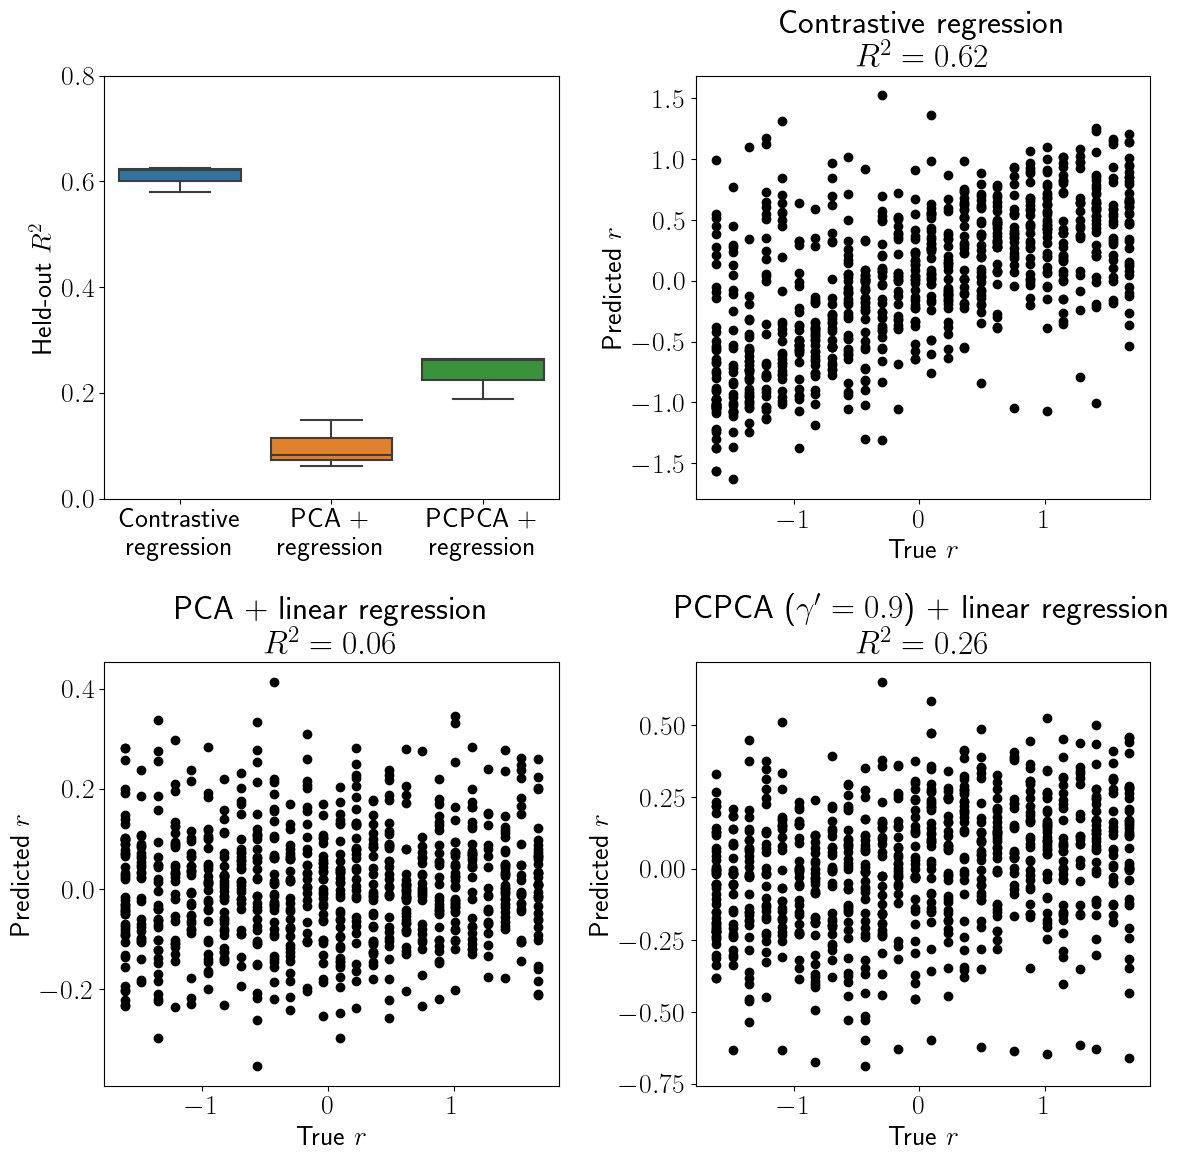

In [12]:
results_df = pd.DataFrame(
    {
        "Method": np.concatenate([["Contrastive\nregression"] * n_splits, ["PCA +\nregression"] * n_splits ,["PCPCA +\nregression"] * n_splits]),
        "R2": np.concatenate([r2_scores_contrastivereg, r2_scores_linreg, r2_scores_pcpca])
    }
)
results_df.to_csv('./out/corrupted_lines_pcpca_R2.csv', index=False)

plt.figure(figsize=(12, 12))
plt.subplot(221)
sns.boxplot(data=results_df, x="Method", y="R2")
plt.xlabel("")
plt.ylabel(r"Held-out $R^2$")
plt.ylim([0, 0.8])

plt.subplot(222)
plt.scatter(R_test, preds_contrastivereg, c="black")
plt.xlabel(r"True $r$")
plt.ylabel(r"Predicted $r$")
plt.title("Contrastive regression\n" + r"$R^2 = " + str(round(r2_contrastivereg, 2)) + "$")


plt.subplot(223)
plt.scatter(R_test, preds_linreg, c="black")
plt.xlabel(r"True $r$")
plt.ylabel(r"Predicted $r$")
plt.title("PCA + linear regression\n" + r"$R^2 = " + str(round(r2_linreg, 2)) + "$")

plt.subplot(224)
plt.scatter(R_test, preds_pcpca, c="black")
plt.xlabel(r"True $r$")
plt.ylabel(r"Predicted $r$")
plt.title("PCPCA ($\gamma^\prime = 0.9$) + linear regression\n" + r"$R^2 = " + str(round(r2_pcpca, 2)) + "$")


plt.tight_layout()
plt.savefig("./out/corrupted_lines_pcpca_preds.png", dpi = 300)
plt.show()